# Project 2. Classification Network

As a preparation stage for project 3, you're going to go through the complete process of training a classification network.

**Note: In this project, you can refer to other open source projects, but you can't directly borrow their code, including the built-in model zoo in pytorch. Also, a lot of the relevant content has been reviewed in Tutorial 4, please go through it again if necessary.**

## Dataset

We're going to use the CIFAR10 dataset for this project.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import numpy as np


cifar10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=lambda x: np.array(x, dtype=np.float32).transpose(2,0,1),
                                         target_transform=None, download=True)
cifar10_test = torchvision.datasets.CIFAR10("CIFAR10", train=False, transform=lambda x: np.array(x, dtype=np.float32).transpose(2,0,1),
                                         target_transform=None, download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12700738.42it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


## Model
Just like the previous project, you need to define your own model structure here.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import numpy as np

# class ClassificationNetwork(nn.Module):
#     def __init__(self):
#         super(ClassificationNetwork, self).__init__()
#         # Convolutional layer block 1
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Convolutional layer block 2
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)

#         # Fully connected layers
#         self.fc1 = nn.Linear(64 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

#     def forward(self, x):
#         # Block 1
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # Block 2
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))

#         # Flatten the output for the fully connected layers
#         x = x.view(-1, 64 * 8 * 8)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
class ClassificationNetwork(nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

# Creating an instance of the network and moving it to GPU
net = ClassificationNetwork().cuda()


## Training

Frist we have the precision testing and the drawing utilities ready.

In [ ]:
def testset_precision(net, testset):
    net.eval()
    dl = DataLoader(testset, batch_size=128)
    total_count = 0
    total_correct = 0
    for data in dl:
        inputs = data[0].cuda()
        targets = data[1].cuda()
        outputs = net(inputs)
        predicted_labels = outputs.argmax(dim=1)
        comparison = predicted_labels == targets
        total_count += predicted_labels.size(0)
        total_correct += comparison.sum()
    net.train()

    return int(total_correct) / int(total_count)

print(f'Inital precision: {testset_precision(net, cifar10_test)}')

from IPython import display
import matplotlib.pyplot as plt
class DrawingBoard:
    def __init__(self, names):
        self.data = {}
        for name in names:
            self.data[name] = []

    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])

    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
        display.clear_output(wait=True)
        plt.show()

Inital precision: 0.8204


Then define your criterion, optimizer, and dataloader

In [ ]:
# modify as you need
net = ClassificationNetwork().cuda()
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
dataloader = DataLoader(cifar10_train, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)

Start training:

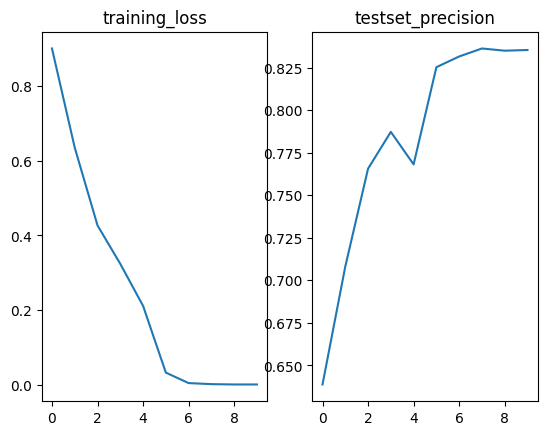

finished


In [ ]:
# modify as you need
print('start training')
db = DrawingBoard(['training_loss', 'testset_precision'])
for epoch in range(10):
    for data in dataloader:
        inputs = data[0].cuda()
        targets = data[1].cuda()
        outputs = net(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    scheduler.step()
    db.update({'training_loss':loss.item(), 'testset_precision': testset_precision(net, cifar10_test)})
    db.draw()

print('finished')

Things to adjust:
- Network structure (including parameters like number of channel, kernel size, batch norm, dropout, pooling etc.)
- Learning rate/lr_scheduler, momentum
- Batch size
- Adjust the number of epochs to run so that it'll stop before overfitting
- All of the data are currently in the file system, which is extremely time consuming to read them in everytime we iterate over the dataset, what could be done to optmize this?

## Challenge

Make your network converges above 0.7 precision (to the point that it is clear your precision will converge over 0.7) in **1 minutes** with **T4 GPU**. (draw precision plot as proof)

**Note: Please don't fill this part if you don't think you have accomplished it.**

**Tips:** 1. Larger learning rate makes the network improve faster, but less stably, lower learning rate makes the network converge faster, consider using optim.lr_scheduler to combine both ideas to make the network improve fast at the beginning and converge fast at the end.

Use the following command to make sure you're using T4 GPU

In [ ]:
!nvidia-smi

Preparation:

In [ ]:
net = ClassificationNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
dataloader = DataLoader(cifar10_train, batch_size=512, shuffle=True)#, num_workers=2, pin_memory=True)

Your training code:

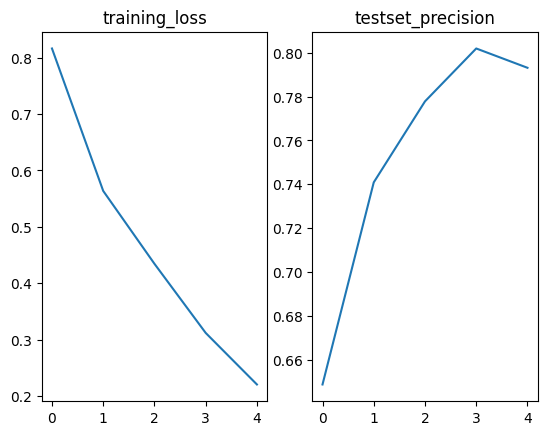

NotImplementedError: Time's up

In [ ]:
import time
import signal
class TimeLimitation:
    def __init__(self, limit):
        self.limit = limit

    def __enter__(self):
        def handler(signum, frame):
            raise NotImplementedError('Time\'s up')
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(self.limit)

    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.alarm(0)


with TimeLimitation(60): # don't forget the indentation
  print('start training')
  db = DrawingBoard(['training_loss', 'testset_precision'])
  for epoch in range(50):
      for data in dataloader:
          inputs = data[0].cuda()
          targets = data[1].cuda()
          outputs = net(inputs)

          optimizer.zero_grad()
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()

      db.update({'training_loss':loss.item(), 'testset_precision': testset_precision(net, cifar10_test)})
      db.draw()

  print('finished')


# Marking Scheme

*   Code implementation: 100%


> * Successfully run through the whole project: 30%
> * Precision above 0.60: 30%
> * Precision above 0.70: 20%
> * Precision above 0.80: 10%
> * Challenge accomplished: 10%